# **Predicting Cancer Type from Tumor-Educated Platelets (TEP) RNA**

This project will use logistic regression, random forests, and shallow neural network methods to predict cancer presence and classification using the GSE68086 data set, with evaluation using metrics such as AUROC, precision-recall, and accuracy.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Dataset

Load and unzip files

*   Series RNA-seq raw counts matrix
*   Series RNA-seq normalized counts matrix
*   Human gene annotation table


In [ ]:
!gunzip /content/drive/MyDrive/Y3/CS184A/Final_Project/GSE68086_norm_counts_TPM_GRCh38.p13_NCBI.tsv.gz
!gunzip /content/drive/MyDrive/Y3/CS184A/Final_Project/GSE68086_raw_counts_GRCh38.p13_NCBI.tsv.gz
!gunzip /content/drive/MyDrive/Y3/CS184A/Final_Project/Human.GRCh38.p13.annot.tsv.gz

gzip: /content/drive/MyDrive/Y3/CS184A/Final_Project/GSE68086_norm_counts_TPM_GRCh38.p13_NCBI.tsv.gz: No such file or directory
gzip: /content/drive/MyDrive/Y3/CS184A/Final_Project/GSE68086_raw_counts_GRCh38.p13_NCBI.tsv.gz: No such file or directory
gzip: /content/drive/MyDrive/Y3/CS184A/Final_Project/Human.GRCh38.p13.annot.tsv.gz: No such file or directory


Load first unzipped `.tsv` file (`GSE68086_norm_counts_TPM_GRCh38.p13_NCBI.tsv`) into a pandas DataFrame. We'll use `pd.read_csv` and specify `sep='\t'` because it's a tab-separated file.

In [ ]:
import pandas as pd

# Set path
norm_counts_path = 'Path to GSE68086_norm_counts_TPM_GRCh38.p13_NCBI.tsv'
try:
    df_norm_counts = pd.read_csv(norm_counts_path, sep='\t')
    print("Successfully loaded GSE68086_norm_counts_TPM_GRCh38.p13_NCBI.tsv")
    display(df_norm_counts.head())
    print(f"Shape of DataFrame: {df_norm_counts.shape}")
except FileNotFoundError:
    print(f"Error: The file '{norm_counts_path}' was not found. Please check the path and file name.")
except Exception as e:
    print(f"An error occurred while loading the file: {e}")

Successfully loaded GSE68086_norm_counts_TPM_GRCh38.p13_NCBI.tsv


,GeneID,GSM1662534,GSM1662535,GSM1662536,GSM1662537,GSM1662538,GSM1662539,GSM1662540,GSM1662541,GSM1662542,...,GSM1817123,GSM1817124,GSM1817125,GSM1817126,GSM1817127,GSM1817128,GSM1817129,GSM1817130,GSM1817131,GSM1817132
0,100287102,28.9100,54.990,143.800,69.600,103.500,115.000,48.620,18.340,142.3000,...,41.4700,22.5400,83.110,46.3100,118.4,46.74,21.840,82.950,69.000,60.9400
1,653635,2.2290,3.694,4.005,1.865,2.281,2.758,4.015,2.196,3.5070,...,2.4260,2.3470,3.578,1.6740,4.4,1.24,1.249,2.267,1.259,1.3130
2,102466751,0.0000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0000,...,0.0000,0.0000,0.000,0.0000,0.0,0.00,0.000,0.000,0.000,0.0000
3,107985730,0.1833,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.1479,...,0.1534,0.7015,0.000,0.1488,0.0,0.00,0.000,0.000,0.000,0.1439
4,100302278,0.0000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0000,...,0.0000,0.0000,0.000,0.5799,0.0,0.00,0.000,0.000,0.000,0.0000


Shape of DataFrame: (39376, 285)


In [ ]:
# Set path
labels_path = "path to Data/GSE68086_series_matrix.txt"

metadata = {}

def clean(x):
  return x.replace('"','').strip()

with open(labels_path, "r") as f:
  for line in f:
    if line.startswith("!Sample_geo_accession"):
      gsm_ids = [clean(x) for x in line.split("\t")[1:]]
      for gsm in gsm_ids:
        metadata[gsm] = {"GSM": gsm}

    if line.startswith("!Sample_characteristics_ch1") and "cancer type" in line.lower():
      vals = [clean(x.split(":",1)[1]) for x in line.split("\t")[1:]]
      for gsm, val in zip(gsm_ids, vals):
        metadata[gsm]["CancerType"] = val

labels = pd.DataFrame(metadata.values())

print(labels.head())
print(f'Shape of labels {labels.shape}')
healthy = labels[labels["CancerType"] == "HC"]
print(healthy.head())
print(f'Shape of healthy {healthy.shape}')


          GSM CancerType
0  GSM1662534     Breast
1  GSM1662535     Breast
2  GSM1662536     Breast
3  GSM1662537     Breast
4  GSM1662538     Breast
Shape of labels (285, 2)
            GSM CancerType
112  GSM1662646         HC
113  GSM1662647         HC
114  GSM1662648         HC
115  GSM1662649         HC
116  GSM1662650         HC
Shape of healthy (55, 2)


In [ ]:
intersect = df_norm_counts.columns.intersection(labels["GSM"])
df = df_norm_counts[intersect]
labels = labels[labels["GSM"].isin(intersect)]
labels = labels.set_index("GSM").loc[intersect]
X = df.T
y = labels['CancerType']
print(X.head())
print(X.shape)
print(y.head())
print(y.shape)

assert(X.shape[0] == y.shape[0])
for i, gsm in enumerate(X.index):
  true_label = labels.loc[gsm, "CancerType"]
  assert true_label == y.iloc[i]

             0      1      2       3      4        5        6       7      \
GSM1662534   28.91  2.229    0.0  0.1833    0.0  0.00000  0.21480  0.4835   
GSM1662535   54.99  3.694    0.0  0.0000    0.0  0.00000  0.00000  0.5552   
GSM1662536  143.80  4.005    0.0  0.0000    0.0  0.00000  0.00000  0.1622   
GSM1662537   69.60  1.865    0.0  0.0000    0.0  0.00000  0.00000  0.1556   
GSM1662538  103.50  2.281    0.0  0.0000    0.0  0.06737  0.08292  0.1244   

             8       9      ...   39366   39367   39368   39369   39370  \
GSM1662534  1.0450   26.32  ...  7294.0  2078.0  2126.0  2068.0  4812.0   
GSM1662535  0.6737   54.83  ...  8746.0  1290.0  1239.0  1315.0  4035.0   
GSM1662536  0.1451  155.30  ...  7697.0  1651.0  1616.0  1617.0  4350.0   
GSM1662537  0.1855   93.19  ...  9365.0  1446.0  1489.0  1507.0  4173.0   
GSM1662538  0.7371  101.80  ...  9063.0  2766.0  2686.0  2640.0  5740.0   

             39371   39372   39373   39374   39375  
GSM1662534  2974.0  1417.0  7183.

# Feature selection

In [ ]:
from sklearn.feature_selection import VarianceThreshold

selector = VarianceThreshold(threshold=70)
X_var = selector.fit_transform(X)
mask = selector.get_support()
selected_genes = X.columns[mask]
X_reduced = pd.DataFrame(X_var,index=X.index,columns=selected_genes)

print(X_reduced.shape)      # (samples, selected_genes)
print(X_reduced[:5])

(284, 2110)
             0       9       18      40      87      99      171     184    \
GSM1662534   28.91   26.32  5504.0  5.1850  11.560  12.920  176.60  12.320   
GSM1662535   54.99   54.83  4597.0  2.4380  11.140  19.660  261.50   2.103   
GSM1662536  143.80  155.30  2321.0  0.8629  14.750  18.530  132.10   2.963   
GSM1662537   69.60   93.19  1632.0  2.9880   7.808   7.664   75.87   6.035   
GSM1662538  103.50  101.80  2589.0  2.3900   7.529  27.950   77.49   2.992   

            192    219    ...   39366   39367   39368   39369   39370   39371  \
GSM1662534  17.33  428.9  ...  7294.0  2078.0  2126.0  2068.0  4812.0  2974.0   
GSM1662535  13.92  337.7  ...  8746.0  1290.0  1239.0  1315.0  4035.0  2384.0   
GSM1662536  22.37  571.6  ...  7697.0  1651.0  1616.0  1617.0  4350.0  2368.0   
GSM1662537   8.61  157.9  ...  9365.0  1446.0  1489.0  1507.0  4173.0  2255.0   
GSM1662538  13.11  234.3  ...  9063.0  2766.0  2686.0  2640.0  5740.0  3338.0   

             39372   39373   393

# Split Data

In [ ]:
from sklearn.model_selection import train_test_split

Xtest, Xtrain, ytest, ytrain = train_test_split(X_reduced, y, test_size=0.2)


In [ ]:
print(ytrain.value_counts())

CancerType
Pancreas         8
HC               8
GBM              7
CRC              6
wt               6
Lung             5
Breast           5
Hepatobiliary    4
EGFR             3
KRAS             2
PIK3CA           2
HER2+            1
Name: count, dtype: int64


In [ ]:
ytrain_merged = ytrain.replace(
    ['Breast', 'HER2+', 'wt', 'KRAS', 'PIK3CA', 'EGFR', 'Hepatobiliary'],
    'Other'
)
ytest_merged = ytest.replace(
    ['Breast', 'HER2+', 'wt', 'KRAS', 'PIK3CA', 'EGFR', 'Hepatobiliary'],
    'Other'
)

In [ ]:
print(ytrain_merged.value_counts(),)
print(ytest_merged.value_counts())

CancerType
Other       23
Pancreas     8
HC           8
GBM          7
CRC          6
Lung         5
Name: count, dtype: int64
CancerType
Other       54
HC          47
Lung        34
GBM         33
CRC         32
Pancreas    27
Name: count, dtype: int64


In [ ]:
test_accuracies = {}
train_accuracies = {}

# Logistic Regression

In [ ]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


#Set pipeline to standardize then logistic regression
pipeline = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("model", LogisticRegression(max_iter=1000, class_weight='balanced'))
    ]
)

params = [
    {
        "model__penalty": ["l2"],
        "model__solver": ["lbfgs"],
        "model__C": [0.01, 0.1, 1, 10, 100]
    },
    {
        "model__penalty": ["l1"],
        "model__solver": ["liblinear"],
        "model__C": [0.01, 0.1, 1, 10, 100]
    }
]

cross_val = StratifiedKFold(n_splits=4, shuffle=True)

grid = GridSearchCV(pipeline, param_grid=params, cv=cross_val, scoring='f1_macro', n_jobs=1)
grid.fit(Xtrain, ytrain_merged)

print(f'Best params: {grid.best_params_}')
print(f'Best score:  {grid.best_score_}')

Best params: {'model__C': 0.01, 'model__penalty': 'l2', 'model__solver': 'lbfgs'}
Best score:  0.3705613830613831


In [ ]:
best_model = grid.best_estimator_

ypred = best_model.predict(Xtest)
test_acc = accuracy_score(ytest_merged, ypred)
print("Test accuracy:", test_acc)
report = classification_report(ytest_merged, ypred)
print("\nClassification report:\n", report)
print("\nConfusion matrix:\n", confusion_matrix(ytest_merged, ypred))
test_accuracies['Logistic Regression'] = test_acc

ypred_train = best_model.predict(Xtrain)
train_acc = accuracy_score(ytrain_merged, ypred_train)
train_accuracies['Logistic Regression'] = train_acc

Test accuracy: 0.5726872246696035

Classification report:
               precision    recall  f1-score   support

         CRC       0.35      0.38      0.36        32
         GBM       0.67      0.55      0.60        33
          HC       0.75      0.94      0.83        47
        Lung       0.78      0.41      0.54        34
       Other       0.60      0.48      0.54        54
    Pancreas       0.35      0.59      0.44        27

    accuracy                           0.57       227
   macro avg       0.58      0.56      0.55       227
weighted avg       0.60      0.57      0.57       227


Confusion matrix:
 [[12  0  2  0  8 10]
 [ 0 18 11  1  1  2]
 [ 0  2 44  0  0  1]
 [ 8  4  1 14  5  2]
 [ 6  3  1  3 26 15]
 [ 8  0  0  0  3 16]]


Classes: ['CRC', 'GBM', 'HC', 'Lung', 'Other', 'Pancreas']
F1 per class: [0.36363636363636365, 0.6, 0.8301886792452831, 0.5384615384615384, 0.5360824742268041, 0.4383561643835616]


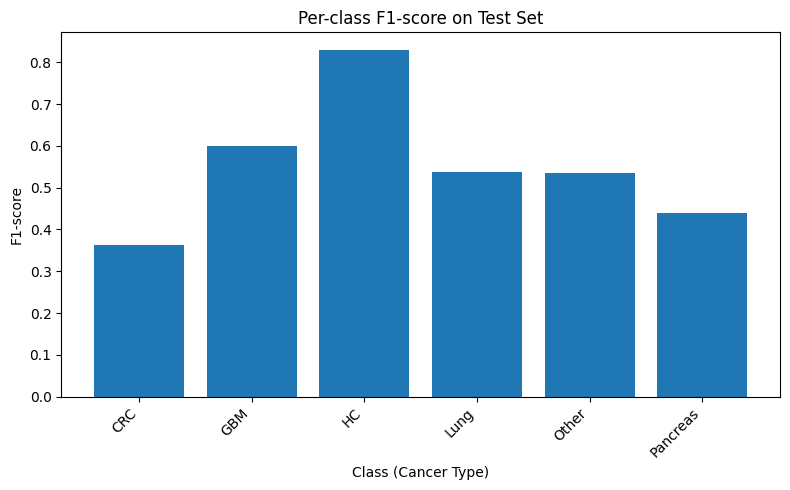

In [ ]:
import matplotlib.pyplot as plt
class_names = []
f1_scores = []

report = classification_report(ytest_merged, ypred, output_dict=True)
for cls, metrics in report.items():
    if cls in ["accuracy", "macro avg", "weighted avg"]:
        continue
    class_names.append(cls)
    f1_scores.append(metrics["f1-score"])

print("Classes:", class_names)
print("F1 per class:", f1_scores)

# Bar chart comparing f-score for each class
plt.figure(figsize=(8, 5))
plt.bar(range(len(class_names)), f1_scores)
plt.xticks(range(len(class_names)), class_names, rotation=45, ha='right')
plt.ylabel("F1-score")
plt.xlabel("Class (Cancer Type)")
plt.title("Per-class F1-score on Test Set")
plt.tight_layout()
plt.show()

# Random Forests

In [ ]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

#Setup pipeline for random forest
pipeline = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("model", RandomForestClassifier(random_state=42))
    ]
)

#The parameters to test the random forest on
params = {
    "model__n_estimators": [100, 200, 300],
    "model__max_depth": [None, 10, 20, 30],
    "model__min_samples_split": [2, 5, 10],
    "model__min_samples_leaf": [1, 2, 4],
    "model__max_features": ["sqrt", "log2"]
}

#K fold cross validation
cross_val = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
grid = GridSearchCV( pipeline, param_grid=params, cv=cross_val, scoring="f1_macro", n_jobs=-1, verbose=1)

#train on training set
grid.fit(Xtrain, ytrain_merged)

print(f"Best params: {grid.best_params_}")
print(f"Best f1 score: {grid.best_score_}")

Fitting 4 folds for each of 216 candidates, totalling 864 fits
Best params: {'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 200}
Best f1 score: 0.31805555555555554


In [ ]:
best_model = grid.best_estimator_

ypred = best_model.predict(Xtest)
test_acc = accuracy_score(ytest_merged, ypred)
print("Test accuracy:", test_acc)
report = classification_report(ytest_merged, ypred)
print("\nClassification report:\n", report)
print("\nConfusion matrix:\n", confusion_matrix(ytest_merged, ypred))
test_accuracies['Random Forest'] = test_acc

ypred_train = best_model.predict(Xtrain)
train_acc = accuracy_score(ytrain_merged, ypred_train)
train_accuracies['Random Forest'] = train_acc

Test accuracy: 0.46255506607929514

Classification report:
               precision    recall  f1-score   support

         CRC       0.20      0.06      0.10        32
         GBM       0.79      0.33      0.47        33
          HC       0.67      0.79      0.73        47
        Lung       1.00      0.06      0.11        34
       Other       0.34      0.78      0.48        54
    Pancreas       0.46      0.41      0.43        27

    accuracy                           0.46       227
   macro avg       0.58      0.40      0.38       227
weighted avg       0.57      0.46      0.41       227


Confusion matrix:
 [[ 2  1  1  0 25  3]
 [ 0 11 13  0  8  1]
 [ 0  0 37  0  8  2]
 [ 3  2  1  2 25  1]
 [ 3  0  3  0 42  6]
 [ 2  0  0  0 14 11]]


Classes: ['CRC', 'GBM', 'HC', 'Lung', 'Other', 'Pancreas']
F1 per class: [0.09523809523809523, 0.46808510638297873, 0.7254901960784313, 0.1111111111111111, 0.4772727272727273, 0.43137254901960786]


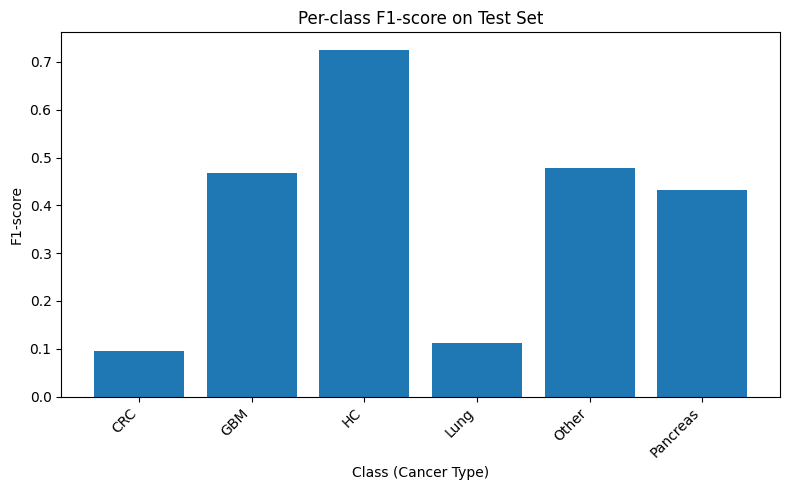

In [ ]:
class_names = []
f1_scores = []

report = classification_report(ytest_merged, ypred, output_dict=True)
for cls, metrics in report.items():
    if cls in ["accuracy", "macro avg", "weighted avg"]:
        continue
    class_names.append(cls)
    f1_scores.append(metrics["f1-score"])

print("Classes:", class_names)
print("F1 per class:", f1_scores)

# Bar chart comparing f-score for each class
plt.figure(figsize=(8, 5))
plt.bar(range(len(class_names)), f1_scores)
plt.xticks(range(len(class_names)), class_names, rotation=45, ha='right')
plt.ylabel("F1-score")
plt.xlabel("Class (Cancer Type)")
plt.title("Per-class F1-score on Test Set")
plt.tight_layout()
plt.show()

# Neural Networks (FF)

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

pipeline_nn = Pipeline([
    ('scaler', StandardScaler()),
    ('model', MLPClassifier(max_iter=1000, random_state=42))
])

params_nn = {
    "model__hidden_layer_sizes": [(128,), (256,), (1128, 64)],
    "model__activation": ['tanh', 'relu'],
    "model__alpha": [0.0001, 0.001, 0.01],
    "model__learning_rate_init": [0.001, 0.01, 0.1]
}

cross_val = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

grid_nn = GridSearchCV(
    pipeline_nn,
    param_grid=params_nn,
    cv=cross_val,
    scoring='f1_macro',
    n_jobs=1
)
grid_nn.fit(Xtrain, ytrain_merged)

print(f'Best params: {grid_nn.best_params_}')
print(f'Best score:  {grid_nn.best_score_}')

Best params: {'model__activation': 'tanh', 'model__alpha': 0.01, 'model__hidden_layer_sizes': (128,), 'model__learning_rate_init': 0.1}
Best score:  0.40149572649572646


In [ ]:
best_model = grid_nn.best_estimator_

ypred = best_model.predict(Xtest)
test_acc = accuracy_score(ytest_merged, ypred)
print("Test accuracy:", test_acc)
report = classification_report(ytest_merged, ypred)
print("\nClassification report:\n", report)
print("\nConfusion matrix:\n", confusion_matrix(ytest_merged, ypred))
test_accuracies['Neural Network'] = test_acc

ypred_train = best_model.predict(Xtrain)
train_acc = accuracy_score(ytrain_merged, ypred_train)
train_accuracies['Neural Network'] = train_acc

Test accuracy: 0.5154185022026432

Classification report:
               precision    recall  f1-score   support

         CRC       0.21      0.12      0.16        32
         GBM       0.51      0.67      0.58        33
          HC       0.83      0.64      0.72        47
        Lung       0.58      0.41      0.48        34
       Other       0.78      0.54      0.64        54
    Pancreas       0.26      0.67      0.38        27

    accuracy                           0.52       227
   macro avg       0.53      0.51      0.49       227
weighted avg       0.58      0.52      0.52       227


Confusion matrix:
 [[ 4  3  0  2  4 19]
 [ 2 22  2  2  2  3]
 [ 0 13 30  2  0  2]
 [ 2  4  3 14  0 11]
 [ 5  1  1  3 29 15]
 [ 6  0  0  1  2 18]]


Classes: ['CRC', 'GBM', 'HC', 'Lung', 'Other', 'Pancreas']
F1 per class: [0.1568627450980392, 0.5789473684210527, 0.7228915662650602, 0.4827586206896552, 0.6373626373626373, 0.37894736842105264]


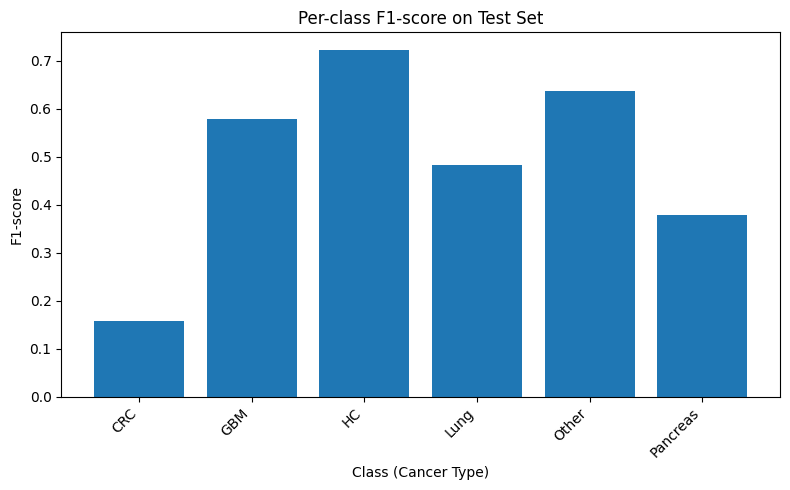

In [ ]:
class_names = []
f1_scores = []

report = classification_report(ytest_merged, ypred, output_dict=True)
for cls, metrics in report.items():
    if cls in ["accuracy", "macro avg", "weighted avg"]:
        continue
    class_names.append(cls)
    f1_scores.append(metrics["f1-score"])

print("Classes:", class_names)
print("F1 per class:", f1_scores)

# Bar chart comparing f-score for each class
plt.figure(figsize=(8, 5))
plt.bar(range(len(class_names)), f1_scores)
plt.xticks(range(len(class_names)), class_names, rotation=45, ha='right')
plt.ylabel("F1-score")
plt.xlabel("Class (Cancer Type)")
plt.title("Per-class F1-score on Test Set")
plt.tight_layout()
plt.show()

# kNN

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA()
pca.fit(Xtrain)

explained_variance = pca.explained_variance_ratio_
cumulative_variance = explained_variance.cumsum()

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.decomposition import PCA

# encode labels (integer format)
le = LabelEncoder()
ytrain_enc = le.fit_transform(ytrain_merged)
ytest_enc = le.transform(ytest_merged)

# PCA reduces dimensionality while preserving variances
# select top 90% components that capture most of the variance
pipeline_knn = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=16)),
    ('model', KNeighborsClassifier())
])

params_knn = {
    "model__n_neighbors": [3, 5, 7, 9, 11, 15, 21],
    "model__weights": ['uniform', 'distance'],
    "model__metric": ['euclidean', 'manhattan']
}

cross_val = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

grid_knn = GridSearchCV(
    pipeline_knn,
    param_grid=params_knn,
    cv=cross_val,
    scoring='f1_macro',
    n_jobs=1
)

grid_knn.fit(Xtrain, ytrain_enc)

print(f'Best params: {grid_knn.best_params_}')
print(f'Best CV score (f1_macro): {grid_knn.best_score_:.4f}\n')

Best params: {'model__metric': 'manhattan', 'model__n_neighbors': 3, 'model__weights': 'distance'}
Best CV score (f1_macro): 0.3446



In [ ]:
best_model = grid_knn.best_estimator_
ypred = best_model.predict(Xtest)
test_acc = accuracy_score(ytest_enc, ypred)
print("Test accuracy:", test_acc)
report = classification_report(ytest_enc, ypred)
print("\nClassification report:\n", report)
print("\nConfusion matrix:\n", confusion_matrix(ytest_enc, ypred))
test_accuracies['kNN'] = test_acc

ypred_train = best_model.predict(Xtrain)
train_acc = accuracy_score(ytrain_enc, ypred_train)
train_accuracies['kNN'] = train_acc

Test accuracy: 0.5022026431718062

Classification report:
               precision    recall  f1-score   support

           0       0.41      0.38      0.39        32
           1       0.56      0.30      0.39        33
           2       0.70      0.81      0.75        47
           3       0.71      0.15      0.24        34
           4       0.43      0.70      0.53        54
           5       0.37      0.41      0.39        27

    accuracy                           0.50       227
   macro avg       0.53      0.46      0.45       227
weighted avg       0.54      0.50      0.48       227


Confusion matrix:
 [[12  2  1  0 13  4]
 [ 2 10 11  0  9  1]
 [ 0  2 38  0  5  2]
 [ 1  3  2  5 15  8]
 [ 8  1  2  1 38  4]
 [ 6  0  0  1  9 11]]


Classes: ['0', '1', '2', '3', '4', '5']
F1 per class: [0.39344262295081966, 0.39215686274509803, 0.7524752475247525, 0.24390243902439024, 0.5314685314685315, 0.38596491228070173]


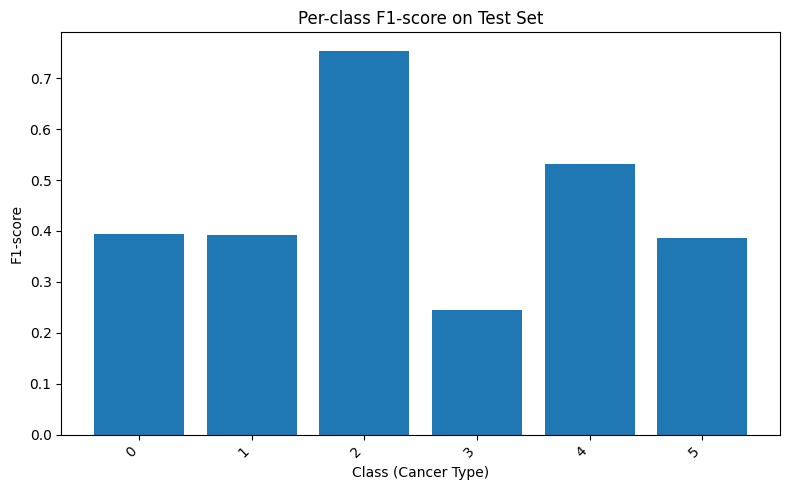

In [ ]:
class_names = []
f1_scores = []

report = classification_report(ytest_enc, ypred, output_dict=True)
for cls, metrics in report.items():
    if cls in ["accuracy", "macro avg", "weighted avg"]:
        continue
    class_names.append(cls)
    f1_scores.append(metrics["f1-score"])

print("Classes:", class_names)
print("F1 per class:", f1_scores)

# Bar chart comparing f-score for each class
plt.figure(figsize=(8, 5))
plt.bar(range(len(class_names)), f1_scores)
plt.xticks(range(len(class_names)), class_names, rotation=45, ha='right')
plt.ylabel("F1-score")
plt.xlabel("Class (Cancer Type)")
plt.title("Per-class F1-score on Test Set")
plt.tight_layout()
plt.show()

#Comparing models

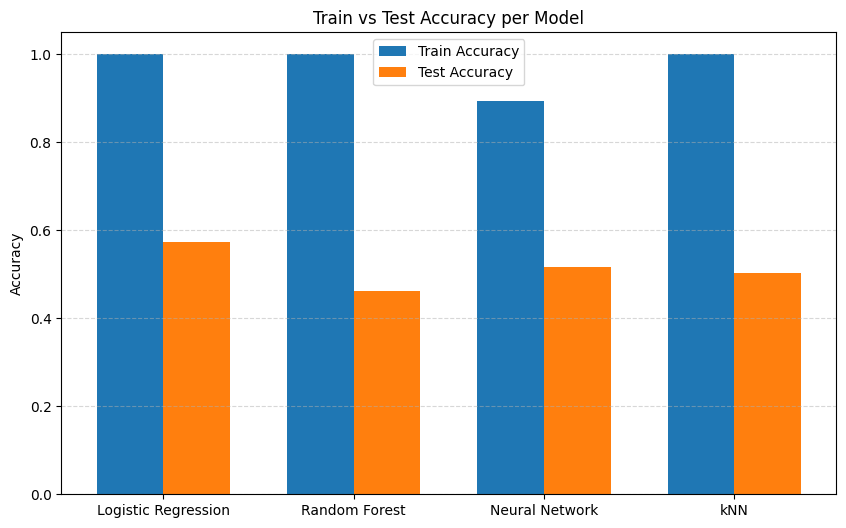

In [ ]:
import numpy as np
models = list(test_accuracies.keys())

test_vals = [test_accuracies[m] for m in models]
train_vals = [train_accuracies[m] for m in models]

x = np.arange(len(models))
width = 0.35

plt.figure(figsize=(10, 6))
plt.bar(x - width/2, train_vals, width, label='Train Accuracy')
plt.bar(x + width/2, test_vals,  width, label='Test Accuracy')

plt.xticks(x, models)
plt.ylabel("Accuracy")
plt.title("Train vs Test Accuracy per Model")
plt.legend()

plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()